## Imports for Model Training and Dataset Preparation

This section includes necessary imports for training a PyTorch-based deep learning model:

- **Standard Libraries**:
  - `os`, `random`, `warnings`, `pandas`, `PIL`, `tqdm`: Used for file operations, progress tracking, image handling, and suppressing unnecessary warnings.

- **Scikit-learn**:
  - `train_test_split`: To split the dataset into training and validation sets.

- **PyTorch and TorchVision**:
  - Core modules (`torch`, `nn`, `optim`) for model training and optimization.
  - `models` and `transforms` from `torchvision` for pretrained models and image preprocessing.
  - `DataLoader` and `Dataset` for efficient data handling and batching during training.

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import random

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", message="The verbose parameter is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.data.dataloader")

## Set Random Seed for Reproducibility

Defines a function to fix random seeds across Python, NumPy, and PyTorch to ensure consistent and reproducible results across different runs.

- Ensures deterministic behavior for debugging and evaluation.

In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed()

In [3]:
DATASET_PATH = "/scratch/panchani.d/Hpc/dataset"

## Dataset Preparation and Image Transformations

This section handles dataset organization and preprocessing:

- **Image Path Loading**:
  - Retrieves image paths and class labels from subfolders within the dataset directory.
  - Constructs a mapping (`class_to_idx`) from class names to numerical labels for training.

- **Data Augmentation (Training Transform)**:
  - Includes resizing, random crops, flips, rotations, and color jitter for improved generalization.

- **Validation Transform**:
  - Applies standard resizing and center cropping for consistent evaluation input.

In [4]:
# Function to get image file paths
def get_image_paths():
    class_folders = [os.path.join(DATASET_PATH, d) for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
    image_paths = []
    class_labels = []
    
    for class_folder in class_folders:
        label = os.path.basename(class_folder)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            if img_path.endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(img_path)
                class_labels.append(label)
    
    return image_paths, class_labels

# Load dataset image paths
image_paths, class_labels = get_image_paths()

# Get unique class names
unique_classes = sorted(set(class_labels))

# Create mapping dictionary
class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_classes)}

# Print the mapping for reference
print(f"Created mapping for {len(unique_classes)} classes:")
for class_name, idx in class_to_idx.items():
    print(f"  {class_name}: {idx}")

# Base transform without augmentation
base_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transforms with data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Use the base transform for validation
val_transform = base_transform

Created mapping for 35 classes:
  Acne And Rosacea Photos: 0
  Actinic Keratosis Basal Cell Carcinoma And Other Malignant Lesions: 1
  Atopic Dermatitis Photos: 2
  Ba  Cellulitis: 3
  Ba Impetigo: 4
  Benign: 5
  Bulluosdiseasephotos: 6
  Cellulitis Impetigo And Other Bacterial Infections: 7
  Eczema Photos: 8
  Exanthems And Drug Eruptions: 9
  Fu Athlete Foot: 10
  Fu Nail Fungus: 11
  Fu Ringworm: 12
  Hair Loss Photos Alopecia And Other Hair Diseases: 13
  Heathy: 14
  Herpes Hpv And Other Stds Photos: 15
  Light Diseases And Disorders Of Pigmentation: 16
  Lupus And Other Connective Tissue Diseases: 17
  Malignant: 18
  Melanoma Skin Cancer Nevi And Moles: 19
  Nail Fungus And Other Nail Disease: 20
  Pa Cutaneous Larva Migrans: 21
  Poison Ivy Photos And Other Contact Dermatitis: 22
  Psoriasis Pictures Lichen Planus And Related Diseases: 23
  Rashes: 24
  Scabies Lyme Disease And Other Infestations And Bites: 25
  Seborrheic Keratoses And Other Benign Tumors: 26
  Systemic Dise

## Dataset Class and DataLoader Setup

- **`SkinDiseaseDataset`**:
  - Custom PyTorch dataset for skin disease classification.
  - Loads images, applies transformations, and handles image read failures with retries and fallback.

- **Data Splitting**:
  - Uses stratified splitting to ensure class balance between training and validation sets.

- **DataLoader Initialization**:
  - Creates efficient data loaders with batching and shuffling for training and validation, while minimizing multiprocessing-related issues.

In [5]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_paths, class_labels, class_to_idx, transform=None):
        """
        Custom dataset for skin disease classification.
        
        Args:
            image_paths (list): List of paths to the images
            class_labels (list): List of class labels (strings) corresponding to the images
            class_to_idx (dict): Mapping from class names to indices
            transform (callable, optional): Optional transform to be applied on images
        """
        self.image_paths = image_paths
        self.class_labels = class_labels
        self.class_to_idx = class_to_idx
        self.transform = transform
            
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        attempts = 0
        max_attempts = 5
        
        while attempts < max_attempts:
            try:
                # Get image path and label
                img_path = self.image_paths[idx]
                class_name = self.class_labels[idx]
                
                # Convert string label to integer index
                label = self.class_to_idx[class_name]
                
                # Load and process image
                image = Image.open(img_path).convert('RGB')
                
                # Apply transformations
                if self.transform:
                    image = self.transform(image)
                    
                return image, label
                
            except Exception as e:
                print(f"Error opening image: {img_path}. Trying another image. Error: {e}")
                attempts += 1
                if attempts >= max_attempts:
                    # Return a black image as fallback
                    print(f"Failed to load image after {max_attempts} attempts.")
                    dummy_img = torch.zeros(3, 224, 224)
                    return dummy_img, 0  # Return 0 as fallback label
                
                # Try a different random image
                idx = random.randint(0, len(self.image_paths) - 1)

# Stratified split to ensure balanced classes - Using 70/30 split
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, class_labels, test_size=0.3, random_state=42, stratify=class_labels
)

# Create datasets
train_dataset = SkinDiseaseDataset(image_paths=train_image_paths, class_labels=train_labels, class_to_idx=class_to_idx, transform=train_transform)
val_dataset = SkinDiseaseDataset(image_paths=val_image_paths, class_labels=val_labels, class_to_idx=class_to_idx, transform=val_transform)

# Create a separate dataset for evaluating training accuracy with the same transform as validation
train_dataset_for_eval = SkinDiseaseDataset(image_paths=train_image_paths, class_labels=train_labels, class_to_idx=class_to_idx, transform=val_transform)

# Reduced number of workers to avoid multiprocessing errors
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
train_loader_for_eval = DataLoader(train_dataset_for_eval, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

## Class Distribution Check, Model Setup, and Training Configuration

- **Class Distribution Check**:
  - Prints the number of samples per class to inspect dataset balance.

- **Model Initialization**:
  - Loads a pretrained EfficientNet-B3 model and customizes the final classification layer.

- **Device Setup**:
  - Moves the model to GPU if available.

- **Class Weighting**:
  - Computes class weights using inverse frequency to address class imbalance during training.
  - Applies these weights in the `CrossEntropyLoss` function.

- **Optimizer and Scheduler**:
  - Uses `AdamW` optimizer with weight decay for regularization.
  - Applies cosine annealing learning rate scheduling to improve convergence.

In [6]:
# Check class distribution
def check_class_distribution(labels, class_to_idx):
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_counts = {}
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    
    print("Class distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")

# Print split information
print(f"Training set: {len(train_image_paths)} images ({len(train_image_paths)/len(image_paths)*100:.1f}%)")
print(f"Validation set: {len(val_image_paths)} images ({len(val_image_paths)/len(image_paths)*100:.1f}%)")

# Load EfficientNet model
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)

# Modify the classifier for our task
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_to_idx))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function with class weighting to handle imbalance
# Calculate class weights
class_counts = {}
for label in train_labels:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

class_weights = {}
total_samples = len(train_labels)
num_classes = len(class_to_idx)
for class_name, count in class_counts.items():
    # Use inverse frequency weighting with smoothing
    class_weights[class_to_idx[class_name]] = (total_samples / (count * num_classes)) ** 0.5

# Convert to tensor
weight_tensor = torch.zeros(num_classes)
for idx, weight in class_weights.items():
    weight_tensor[idx] = weight

weight_tensor = weight_tensor.to(device)

# Using weighted cross entropy loss
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

# Optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler with cosine annealing
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

Training set: 171525 images (70.0%)
Validation set: 73512 images (30.0%)


## Model Training Loop and Evaluation

This section implements the full training workflow with evaluation and visualization:

- **`compute_accuracy()`**:
  - Evaluates model accuracy on any given DataLoader.

- **Training Loop**:
  - Trains the model for a specified number of epochs using mixed precision for faster training.
  - Tracks training/validation loss and accuracy.
  - Saves the best-performing model based on validation accuracy.
  - Uses a cosine annealing learning rate scheduler.

- **Metrics Logging**:
  - Stores loss and accuracy values per epoch in a CSV file.
  - Visualizes training vs. validation loss and accuracy across epochs and saves the plot.

Starting epoch: 1


  0%|          | 0/2681 [00:00<?, ?it/s]

Model saved with validation accuracy: 78.71%
Epoch 1/2
LR: 0.000098
Train Loss: 1.5937, Train Acc: 79.62%
Val Loss: 0.7292, Val Acc: 78.71%
------------------------------------------------------------
Starting epoch: 2


  0%|          | 0/2681 [00:00<?, ?it/s]

Model saved with validation accuracy: 89.64%
Epoch 2/2
LR: 0.000091
Train Loss: 0.9014, Train Acc: 90.96%
Val Loss: 0.3661, Val Acc: 89.64%
------------------------------------------------------------
Training completed. Best validation accuracy: 89.64%


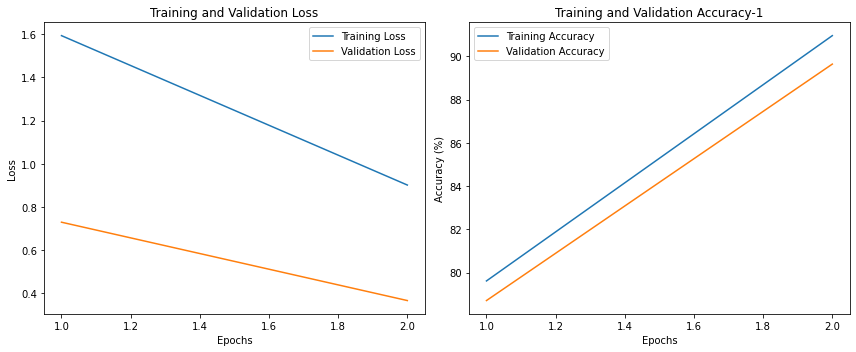

In [7]:
# Function to compute accuracy
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop with validation
num_epochs = 2
best_val_acc = 0.0

# Implement mixed precision training
scaler = torch.amp.GradScaler('cuda')  # For mixed precision training

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f'Starting epoch: {epoch + 1}')
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        # Backward pass and optimize with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Statistics (for monitoring during training, not for final accuracy)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    
    # Compute training accuracy without augmentation for fair comparison
    train_acc = compute_accuracy(model, train_loader_for_eval, device)
    
    # Save training metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            val_running_loss += loss.item()
    
    val_loss = val_running_loss / len(val_loader)
    val_acc = compute_accuracy(model, val_loader, device)
    
    # Save validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model-1.1.pth')
        print(f"Model saved with validation accuracy: {val_acc:.2f}%")
    
    # Print statistics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"LR: {current_lr:.6f}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print("-" * 60)

print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")

# Save metrics to file
import pandas as pd
metrics_df = pd.DataFrame({
    'epoch': list(range(1, num_epochs + 1)),
    'train_loss': train_losses,
    'train_accuracy': train_accuracies,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies
})
metrics_df.to_csv('training_metrics-1.csv', index=False)

# Plot training and validation metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy-1')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics_plot-1.png')
plt.show()